In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from packages.DataProcessing import split_dataset, tfrecords

In [2]:
IMG_HEIGHT = 300
IMG_WIDTH = 300
N_SPLITS = 3

In [3]:
df = pd.read_csv("./input/train.csv")

In [4]:
class_names = [       "Abdomen",        "Ankle", "Cervical Spine",  "Chest", 
                    "Clavicles",        "Elbow",           "Feet", "Finger",
                      "Forearm",         "Hand",            "Hip",   "Knee",  
                    "Lower Leg", "Lumbar Spine",         "Others", "Pelvis", 
                     "Shoulder",        "Sinus",          "Skull",  "Thigh", 
               "Thoracic Spine",        "Wrist"]

In [5]:
class_names = np.array(class_names)

In [6]:
np.save("./output/class_names.npy", class_names)

In [7]:
targets = np.zeros((len(df.Target), 22), dtype=int)
for i, t in enumerate(df.Target):
    target = t.strip().split()
    for j in target:
        targets[i, int(j)] = 1

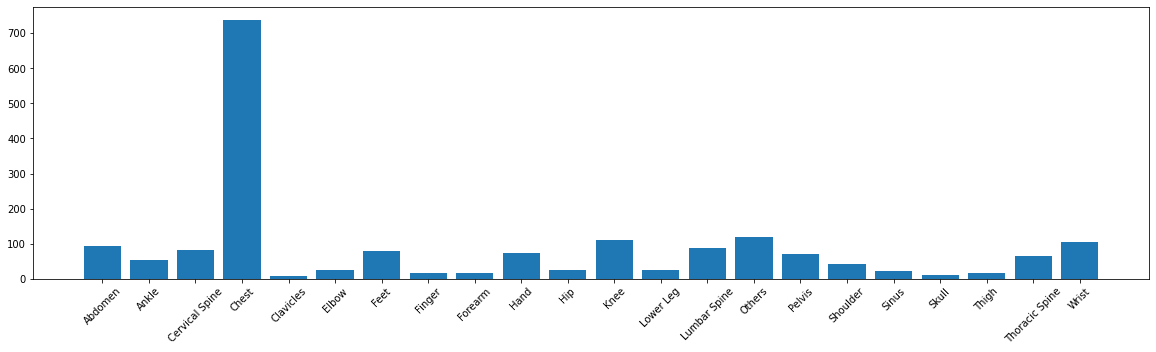

In [8]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(22), targets.sum(axis=0))
plt.xticks(ticks=np.arange(22), labels=class_names, rotation=45)
plt.show()

In [9]:
path_images = []
folder = ".\\input\\train\\train\\"
for root, dirs, files in os.walk(folder, topdown=False):
    if files:
        if files[0][-3:] == 'dcm':
            path_images.append(root + "\\" + files[0])

In [10]:
for i in range(len(df)):
    id = df.iloc[i].SOPInstanceUID
    for j in path_images:
        if j[-70:-6] == id:
            df.iloc[i].SOPInstanceUID = j
            break

In [11]:
df.head()

,SOPInstanceUID,Target
0,.\input\train\train\1332\1.2.826.0.1.3680043.8...,0
1,.\input\train\train\299\1.2.826.0.1.3680043.8....,15
2,.\input\train\train\259\1.2.826.0.1.3680043.8....,12
3,.\input\train\train\129\1.2.826.0.1.3680043.8....,14
4,.\input\train\train\365\1.2.826.0.1.3680043.8....,3


In [12]:
df_test = pd.read_csv("./input/sample_submission.csv")

In [13]:
path_test_images = []
folder = ".\\input\\test\\test\\"
for root, dirs, files in os.walk(folder, topdown=False):
    if files:
        if files[0][-3:] == 'dcm':
            path_test_images.append(root + "\\" + files[0])

In [14]:
for i in range(len(df_test)):
    id = df_test.iloc[i].SOPInstanceUID
    for j in path_test_images:
        if j[-70:-6] == id:
            df_test.iloc[i].SOPInstanceUID = j
            break

In [15]:
df_test.head()

,SOPInstanceUID,Target
0,.\input\test\test\736\1.2.826.0.1.3680043.8.49...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,.\input\test\test\1012\1.2.826.0.1.3680043.8.4...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,.\input\test\test\502\1.2.826.0.1.3680043.8.49...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,.\input\test\test\1336\1.2.826.0.1.3680043.8.4...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,.\input\test\test\1017\1.2.826.0.1.3680043.8.4...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [16]:
ds_splits = split_dataset(X=df.SOPInstanceUID, y=targets, N_SPLITS=N_SPLITS)

train size: 1159
valid size: 579


In [17]:
ds_splits['test'] = df_test.SOPInstanceUID

In [18]:
train_target = ds_splits['train'][1]
valid_target = ds_splits['valid'][1]
np.save("./output/train_target.npy", train_target)
np.save("./output/valid_target.npy", valid_target)

In [19]:
os.mkdir(f"./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}")

In [20]:
# Writing TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)

records.WriteTFRecords(ds_splits, path=f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}')

100%|██████████| 743/743 [32:14<00:00,  2.60s/it]


In [21]:
# Reading TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)
train_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/train.tfrecords')
valid_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/valid.tfrecords')
# test_ds = records.get_test_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/test.tfrecords')

In [22]:
BATCH_SIZE = 16
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
# test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

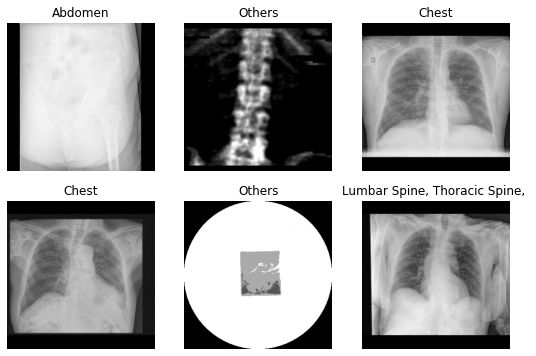

In [23]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    label = label_batch[i].numpy()
    if label.sum() == 1:
        plt.title(class_names[np.argmax(label)])
    else:
        titles = ""
        for j in np.where(label == 1)[0]:
            titles = titles + class_names[j] + ", "
        plt.title(titles)
    plt.axis("off")
plt.show()